# Diffusion Processes on Complex Networks

## Assignment 5

In [58]:
# import sys
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install scipy
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install imageio

Link to my GitLap repository with solution: https://gitlab.com/249755/diffusion-processes-on-complex-networks.git

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

### Ex 1

#### a)

$\frac{dS(t)}{dt}=-\beta SI$

$\frac{dI(t)}{dt}=\beta SI-rI$

$\frac{dR(t)}{dt}=rI$

Resolve above system of differential equations numerically for different sets of parameters.

$R_0=\frac{\beta N}{r}$

Draw 9 plots for differens sets of parameters ($4$ - $5$ of them should led to $R_0>1$, and the rest to $R_0<1$).

In [49]:
def epidemic_ODE(t, z, beta, r):
    S, I, R = z
    return [-beta*S*I, beta*S*I-r*I, r*I]

In [161]:
def solve_epidemic_ODE(N, I0, beta, r, T):
    sol = solve_ivp(epidemic_ODE, [0, T], [N-I0, I0, 0], args=(beta, r), 
                                            t_eval=np.linspace(0, T, 500))
    plt.plot(sol.t, sol.y.T)
    plt.legend(['S', 'I', 'R'], loc='best')
    plt.title(f'$\\beta={beta}$, $r={r}$, $R_0={round(beta*N/r, 2)}$')

In [51]:
N = 1
I0 = 0.02

In [52]:
betas = [1.5, 0.65, 0.33]
rs = [0.33, 0.5, 0.7]

Plots for 9 sets of parameters:

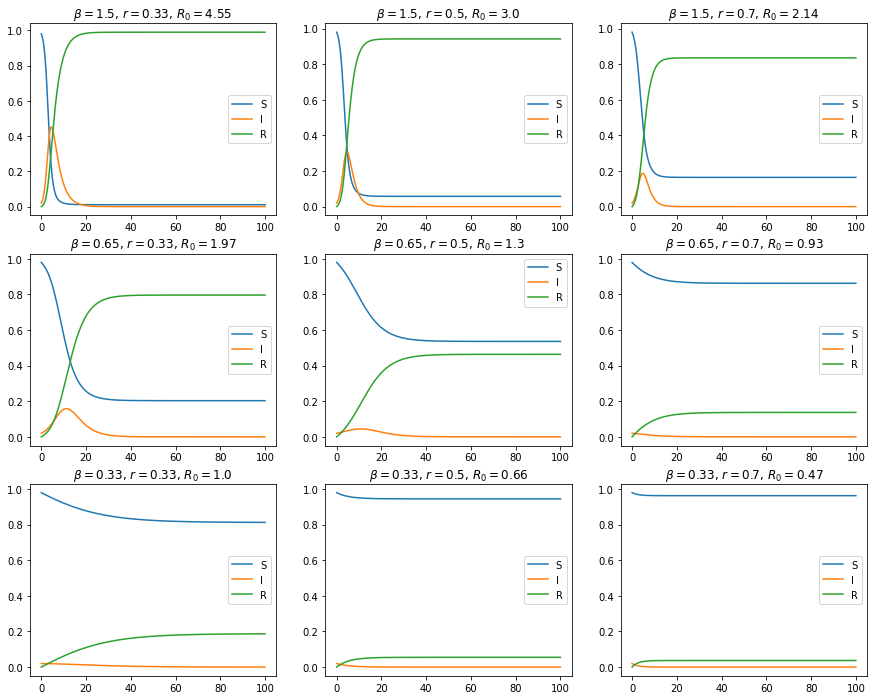

In [53]:
plt.figure(figsize=(15, 12))
for i, beta in enumerate(betas):
    for j, r in enumerate(rs):
        plt.subplot(3, 3, int(3*i + j + 1))
        solve_epidemic_ODE(N, I0, beta, r, 100)

#### b)

$\frac{dS(t)}{dt}=-\beta SI$

$\frac{dI(t)}{dt}=\beta SI-rI$

Resolve above reduced system of differential equations and draw phase portraits for sets of parameters from previous point.

In [54]:
def epidemic_ODE_2(z, t, beta, r):
    S, I = z
    return [-beta*S*I, beta*S*I-r*I]

In [55]:
def phase_portrait(N, beta, r):
    i = np.linspace(0, N, 20)
    s = np.linspace(0, N, 20)
    I, S = np.meshgrid(i, s)
    t = 0
    u, v = np.zeros(I.shape), np.zeros(S.shape)
    NI, NJ = I.shape
    for i in range(NI):
        for j in range(NJ):
            x = I[i, j]
            y = S[i, j]
            yprime = epidemic_ODE_2([x, y], t, beta, r)
            u[i,j] = yprime[0]
            v[i,j] = yprime[1]
    plt.quiver(I, S, u, v, color='r')
    plt.xlabel('$I(t)$')
    plt.ylabel('$S(t)$')
    plt.title(f'$\\beta={beta}$, $r={r}$, $R_0={round(beta*N/r, 2)}$')

Phase portraits for 9 sets of parameters:

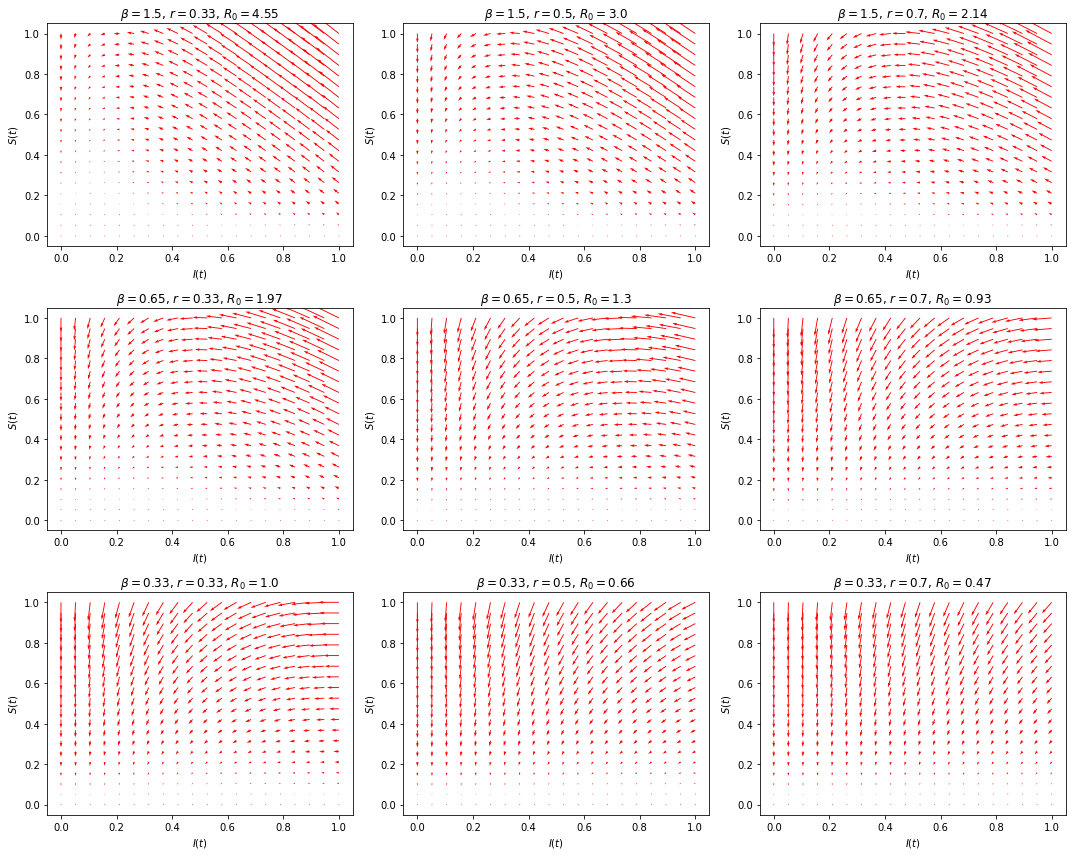

In [56]:
plt.figure(figsize=(15, 12))
for i, beta in enumerate(betas):
    for j, r in enumerate(rs):
        plt.subplot(3, 3, int(3*i + j + 1))
        phase_portrait(N, beta, r)
        plt.tight_layout()

#### c)

For different combinations of $r$ and $\beta$ determine the total number of individuals infected during an epidemic and then calculate $R_0$ for each parameter set. Plot the total number of infections as a function of $R_0$.

Text(0.5, 1.0, 'Total number of infected people')

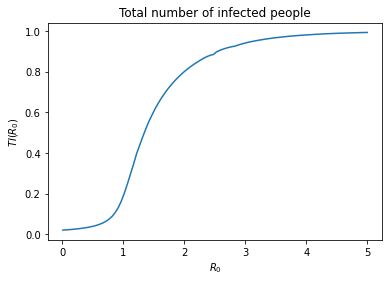

In [57]:
r = 1
betas = np.linspace(0.01, 5, 100)
R0 = []
TI = []
for beta in betas:
    sol = solve_ivp(epidemic_ODE, [0, 100], [N-I0, I0, 0], args=(beta, r), 
                                            t_eval=np.linspace(0, 100, 500))
    R0.append(N*beta/r)
    TI.append(sol.y.T[:,2][499])
plt.plot(R0, TI)
plt.xlabel('$R_0$')
plt.ylabel('$TI(R_0)$')
plt.title('Total number of infected people')

### Ex 2

In [118]:
from l2 import *
from l3 import *
from l4 import *
import matplotlib.lines as mlines

#### a)

Simulate the SIR model on a 2D lattice, a random graph, a Watts-Strogatz graph and a Barabasi-Albert graph. Keep the number of nodes low, e.g. equal to 100 (performance issues).

In [5]:
N = 100

Generating four graphs:

In [6]:
l_graph = lattice_graph(N)
ER_graph = Erdos_Renji(N, 0.1)
WS_graph = Watts_Strogatz(N, 4, 0.1)
BA_graph = Barabasi_Albert(N, 2, 2)

Function which simulates SIR model on given graph from given infected node:

In [6]:
def SIR_model(graph, start_node, p, T):
    states = {'S': list(np.zeros(T)), 'I': list(np.zeros(T)), 'R': list(np.zeros(T))}
    infected = [start_node]
    susceptible = graph.get_vertices()
    susceptible.remove(start_node)
    recovered = []
    states['S'][0] = susceptible
    states['I'][0] = infected
    states['R'][0] = recovered
    for t in range(1, T):
        recovered = states['R'][t-1] + states['I'][t-1]
        infected = []
        for i in states['I'][t-1]:
            for n in graph.get_neighbors(i):
                r = np.random.rand()
                if (r<p) and (n in states['S'][t-1]) and (n not in infected):
                    infected.append(n)
        susceptible = states['S'][t-1].copy()
        for i in infected:
            susceptible.remove(i)
        states['S'][t] = susceptible
        states['I'][t] = infected
        states['R'][t] = recovered
    return states

#### b)

Record the fraction of infected nodes in the network at each time point for three different values of $p$. Because the SIR dynamics is stochastic, you will want to simulate each infection multiple times with the same starting node. Plot the average of this runs over time for each value of $p$.

$p = 0.2$, $p=0.5$, $p=0.7$

Function which plots fractions of infected nodes in time t:

In [42]:
def plot_infected(graph, start_node, ps, T, MC, model):
    for p in ps:
        mat = []
        for i in range(MC):
            infected = model(graph, start_node, p, T)['I']
            mat.append([len(l) for l in infected])
            num_infected = np.array(mat).mean(axis=0)
        plt.plot(np.arange(T), num_infected/graph.num_vertices, label=f"$p={p}$")
    plt.legend()
    plt.xlabel('t')
    plt.ylabel('fraction of infected nodes')
        

In [63]:
ps = [0.2, 0.5, 0.7]

##### Lattice

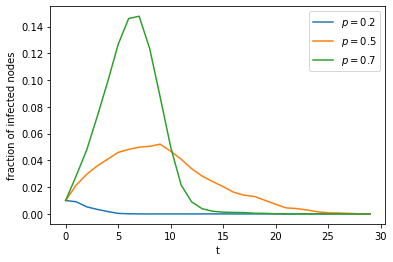

In [64]:
plot_infected(l_graph, 7, ps, 30, 100, SIR_model)

##### Erdos-Renji

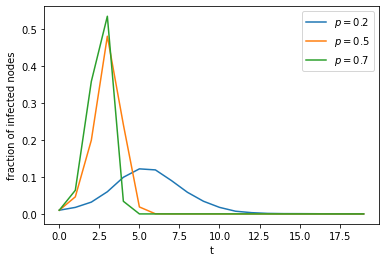

In [65]:
plot_infected(ER_graph, 7, ps, 20, 100, SIR_model)

##### Watts-Strogatz

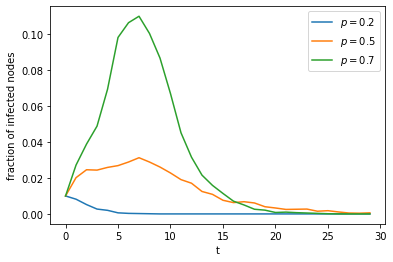

In [66]:
plot_infected(WS_graph, 7, ps, 30, 100, SIR_model)

##### Barabasi-Albert

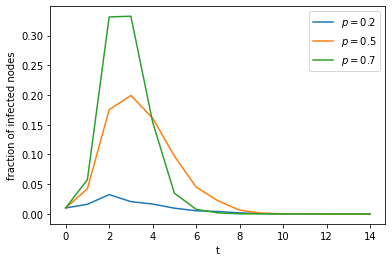

In [67]:
plot_infected(BA_graph, 7, ps, 15, 100, SIR_model)

#### c)

Discuss how the infection curves compare to the behavior seen in the
ODE model.

For bigger $p$, it behaves as for bigger $R$ in ODE model and conversely.

#### d)

Select $p=[0.05, \ldots, 0.95]$. Simulate the SIR dynamics on the network starting with a random node. Measure the total propotion of the network that becomes infected, the time to clear infection and the time to the largest number of infected nodes. Be sure to simulate the infection enough times: $MC=10$ (each run starting from a different randomly chosen starting node) that you can reasonably estimate the mean of each of these measures. For each measure plot it as a function of $p$. Make one plot for each measure, including a separate line (labeled appropriately) for each network.

Helper function which calculates total proportion of ever infected people for given graph, start node and $p$:

In [70]:
def total_proportion(graph, start_node, p, T, model):
    states = model(graph, start_node, p, T)
    num_inf = [len(states['I'][t]) for t in range(len(states['I']))]
    num_rec = [len(states['R'][t]) for t in range(len(states['R']))]
    return num_rec[num_inf.index(0)]/graph.num_vertices

Helper function which calculates time to clear the infection for given graph, start node and $p$:

In [71]:
def time_to_clear(graph, start_node, p, T, model):
    states = model(graph, start_node, p, T)
    num_inf = [len(states['I'][t]) for t in range(len(states['I']))]
    return num_inf.index(0)

Helper function which calculates time to the largest number of infected nodes for given graph, start node and $p$:

In [72]:
def time_to_largest_I(graph, start_node, p, T, model):
    states = model(graph, start_node, p, T)
    num_inf = [len(states['I'][t]) for t in range(len(states['I']))]
    return num_inf.index(max(num_inf))

Helper function which plots choosen measure:

In [73]:
def plot_measure(graphs, ps, MC, T, measure, model):
    for graph in graphs:
        mm = list(np.zeros(len(ps)))
        for i, p in enumerate(ps):
            mm[i] = np.mean([measure(graph, np.random.choice(graph.get_vertices()), 
                                                    p, T, model) for m in range(MC)])
        plt.plot(ps, mm)
    plt.legend(['lattice', 'ER', 'WS', 'BA'])
    plt.xlabel('p')
    plt.tight_layout()

Function for plotting everything:

In [74]:
def measures(graphs, ps, MC, T, model):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plot_measure(graphs, ps, MC, T, total_proportion, model)
    plt.ylabel('total proportion of infected nodes')
    plt.title('Total proportion of ever infected nodes')

    plt.subplot(1, 3, 2)
    plot_measure(graphs, ps, MC, T, time_to_clear, model)
    plt.title('Time to clear the infection')
    plt.ylabel('t')

    plt.subplot(1, 3, 3)
    plot_measure(graphs, ps, MC, T, time_to_largest_I, model)
    plt.title('Time to the largest number of infected nodes')
    plt.ylabel('t')

In [73]:
graphs = [l_graph, ER_graph, WS_graph, BA_graph]
ps = np.arange(0.05, 1, 0.05)

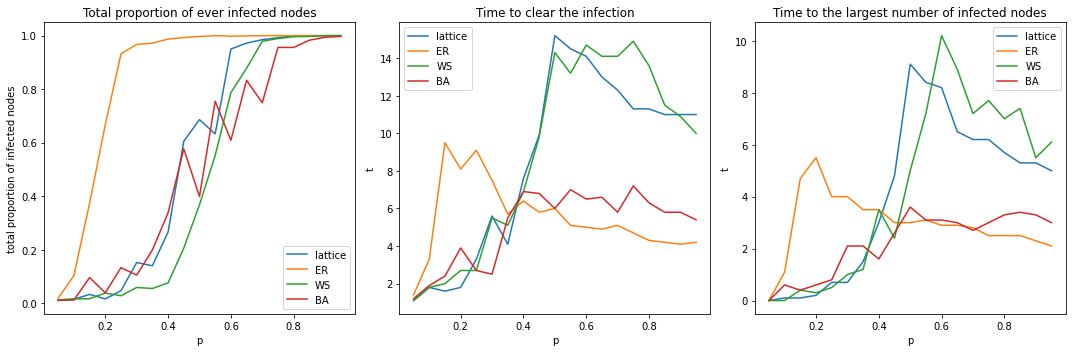

In [74]:
measures(graphs, ps, 10, 100, SIR_model)

#### e)

What each of the above measures tells you about the different networks?

Total proportion of ever infected nodes gives us information about density of the graph. For bigger density, curve of total proportion of ever infected nodes with respect to $p$, increases faster. Because of bigger degrees of all the nodes in graph and no nodes with very small degree infection spreads faster and time to clear the infection is the biggest for smaller $p$ (as in Erdos-Renji case). We can see that on the first plot lattice, Barabasi-Albert and Watts-Strogatz graphs look very similarly, but then curve of time to clear the infection and to the largest number of infected nodes with respect to $p$ for Barabasi-Albert graph behaves differently. It can be caused by some ,,lonely'' nodes in Barabasi-Albert type graph, which means nodes with smaller degrees far away from the center of the graph. Such nodes sometimes make impossible spreading of epidemic, and that's why the curve becomes flat instead of increasing with $p$.

#### f)

For each network of size $N = 30$ for choosen $p$, visualize a single run of the infection spreading in form of an animated gif or an avi file.

Helper function, which plots state of epidemic for choosen t and given states and graph:

In [106]:
def visualise_SIR(graph, t, states):
    x = []
    y = []
    n = len(graph.get_vertices())
    angle = 2*np.pi/(n)
    for i in range(n):
        angle_i = i*angle
        x.append(np.cos(angle_i))
        y.append(np.sin(angle_i))
    plt.gca().set_aspect('equal')
    plt.plot(x, y, '.')
    for i in range(n):
        plt.text(x[i], y[i], str(graph.get_vertices()[i]), fontsize=12)
    for edge in graph.get_edges():
        plt.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], 'bo-', 
                                                                        alpha=0.5)
    for inf in states['I'][t]:
        plt.plot(x[inf], y[inf], 'ro')
    for rec in states['R'][t]:
        plt.plot(x[rec], y[rec], 'ko')


Function which animates epidemic spreading for given graph, start node, $p$, number of steps and model:

In [126]:
def gif_SIR(graph, start_node, p, T, model, folder = 'anim/', name = 'anim'):
    states = model(graph, start_node, p, T)
    plt.figure()
    list_of_jpg = []
    list_of_names = []
    for t in range(T):
        visualise_SIR(graph, t, states)
        legend_dict = { 'S' : 'blue', 'I' : 'red', 'R' : 'black' }
        patchList = []
        for key in legend_dict:
            data_key = mlines.Line2D([], [], color=legend_dict[key], marker='o', 
                                                        linestyle='None', label=key)
            patchList.append(data_key)
        plt.legend(handles=patchList, loc='center')
        dest = folder + str(t) + '.png'
        list_of_names.append(dest)
        plt.savefig(dest)
        list_of_jpg.append(imageio.imread(dest))
        plt.clf()
    imageio.mimwrite(folder + name + '.gif', list_of_jpg, duration=0.7)  
    for i in range(len(list_of_names)): 
        os.remove(list_of_names[i])

In [124]:
# gif_SIR(lattice_graph(25), 3, 0.5, 12, SIR_model, 'ex2/', name = 'lattice')

In [128]:
# gif_SIR(Erdos_Renji(30, 0.17), 3, 0.4, 12, SIR_model, 'ex2/', name = 'ER')

In [130]:
# gif_SIR(Watts_Strogatz(30, 4, 0.4), 3, 0.5, 12, SIR_model, 'ex2/', name = 'WS')

In [137]:
# gif_SIR(Barabasi_Albert(30, 2, 2), 3, 0.4, 9, SIR_model, 'ex2/', name = 'BA')

Gif files are located in ex2 folder as lattice.gif, ER.gif, WS.gif, BA.gif in l5 folder in my Git repository.

### Ex 3

#### a)

Repeat the above simulation in the asynchronous update scheme.

In [139]:
def SIR_model_async(graph, start_node, p, T):
    states = {'S': list(np.zeros(T)), 'I': list(np.zeros(T)), 'R': list(np.zeros(T))}
    infected = [start_node]
    susceptible = graph.get_vertices()
    susceptible.remove(start_node)
    recovered = []
    states['S'][0] = susceptible
    states['I'][0] = infected
    states['R'][0] = recovered
    for t in range(1, T):
        old_infected = states['I'][t-1].copy()
        infected = []
        recovered = []
        for _ in range(graph.num_vertices):
            i = np.random.choice(graph.get_vertices())
            if i in states['I'][t-1]:
                for n in graph.get_neighbors(i):
                    r = np.random.rand()
                    if (r<p) and (n in states['S'][t-1]) and (n not in infected):
                        infected.append(n)
                if i not in recovered:
                    recovered.append(i)
        susceptible = states['S'][t-1].copy()
        for i in infected:
            susceptible.remove(i)
        for i in recovered:
            old_infected.remove(i)
        recovered = states['R'][t-1] + recovered
        infected = old_infected + infected
        states['S'][t] = susceptible
        states['I'][t] = infected
        states['R'][t] = recovered
    return states

### b) 

Repeat the analysis from previous ex for the new simulation.

In [140]:
ps = [0.2, 0.5, 0.7]

##### Lattice

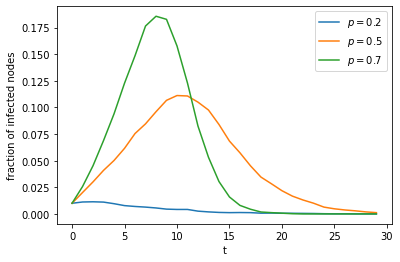

In [141]:
plot_infected(l_graph, 7, ps, 30, 100, SIR_model_async)

##### Erdos-Renji

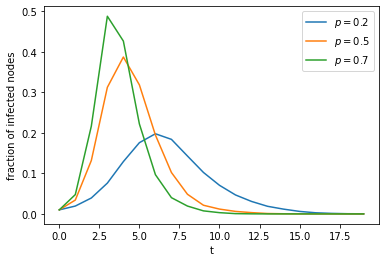

In [142]:
plot_infected(ER_graph, 7, ps, 20, 100, SIR_model_async)

##### Watts-Strogatz

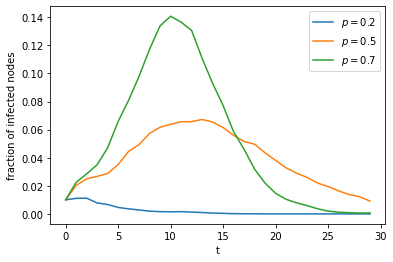

In [143]:
plot_infected(WS_graph, 7, ps, 30, 100, SIR_model_async)

##### Barabasi-Albert

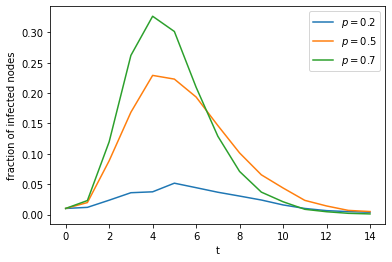

In [144]:
plot_infected(BA_graph, 7, ps, 15, 100, SIR_model_async)

In [145]:
graphs = [l_graph, ER_graph, WS_graph, BA_graph]
ps = np.arange(0.05, 1, 0.05)

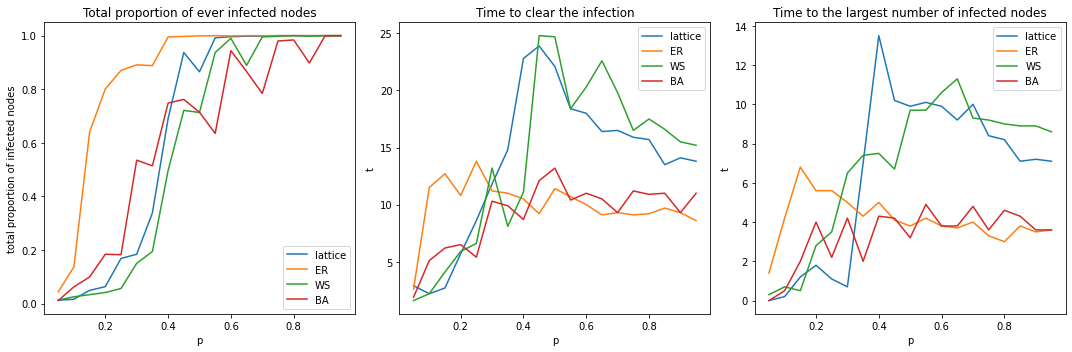

In [146]:
measures(graphs, ps, 10, 100, SIR_model_async)

### c) 

Analyze the impact of the updating scheme on the final outcome of the model.

Total proportion of ever infected nodes doesn't change a lot instead of increasing a little bit slower with respect to $p$. Time to clear the infection is much bigger for all cases and the same with time to the largest number of infected nodes. General shape of all curves doesn't change very much, but epidemic spreading slowed down for sure.

#### d)

For each network of size $N = 30$ for choosen $p$, visualize a single run of the infection spreading in form of an animated gif or an avi file.

In [141]:
# gif_SIR(lattice_graph(25), 3, 0.5, 12, SIR_model_async, 'ex3/', name = 'lattice')

In [143]:
# gif_SIR(Erdos_Renji(30, 0.17), 3, 0.4, 12, SIR_model_async, 'ex3/', name = 'ER')

In [153]:
# gif_SIR(Watts_Strogatz(30, 4, 0.4), 3, 0.5, 16, SIR_model_async, 'ex3/', name = 'WS')

In [160]:
# gif_SIR(Barabasi_Albert(30, 2, 2), 3, 0.4, 16, SIR_model_async, 'ex3/', name = 'BA')

Gif files are located in ex3 folder as lattice.gif, ER.gif, WS.gif, BA.gif in l5 folder in my Git repository.